Annotate the growth cones in the timelapse. Load the signal channel and background, save an rgb .npy array for visualizing later. Main purpose here is however to label growth cones. Create some empty shapes layers in napari, then label manually. After that, run the SAVE axon labels cells. One can also read in already labelled axons using the LOAD cell. This also checks if a sequence of detections is continueos (no timepoints skipped).

In [1]:
import napari
from tifffile import imread
%gui qt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import os

In [2]:
inp_path = '/run/media/loaloa/lbb_ssd/timelapse01_40_min_processed/'
inp_path = '/home/loaloa/Documents/'
outp_path = '../tl140_outputdata'

red_file = inp_path+'G001_red_compr.deflate.tif'
redchannel = imread(red_file)
sizet, sizey, sizex = redchannel.shape
ymin, ymax = 0, sizey
xmin, xmax = 0, sizex

# tranl_file = inp_path+'G001_grey_compr.deflate.tif'
# greychannel = imread(tranl_file)[0]

# viewer.add_points(name='outputchannel')
target = (991, 2746)
sizet = redchannel.shape[0]

In [3]:
# mask image to relevant area
excl_mask = np.load(f'{outp_path}/mask_wells_excl.npy')
mask = np.load(f'{outp_path}/mask_wells_incl.npy')
# greychannel[~mask.astype(bool)] = 0
redchannel[:,~mask.astype(bool)] = 0

In [4]:
# create merged image (for showcasing results later)
grey = greychannel*3
rgb_image = np.stack([grey]*3, -1)
rgb_image = np.stack([rgb_image]*redchannel.shape[0], 0)

r = redchannel*13
rgb_image[:,:,:,0] += r

np.save(f'{outp_path}/rgb_seq_vanilla.npy', rgb_image)

NameError: name 'greychannel' is not defined

In [4]:
with napari.gui_qt():
    viewer = napari.Viewer()

In [10]:
ymin, ymax = 1300, 2500
xmin, xmax = 0, 2000
redchannel = redchannel[:, ymin:ymax,xmin:xmax]
sizey, sizex = redchannel.shape[1:]
# greychannel = greychannel[1300:,:2000]


In [5]:
viewer.add_image(redchannel)
viewer.layers['redchannel'].blending = 'additive'
viewer.layers['redchannel'].colormap = 'red'
viewer.layers['redchannel'].contrast_limits = [0,2700]

# viewer.add_image(greychannel)
# viewer.layers['greychannel'].blending='additive'
# viewer.layers['greychannel'].opacity = .1
# viewer.layers['greychannel'].gamma = .6

In [12]:
# compute motion and add to viewer
blur_strength = 3
lowerlim = 100
print(f'Calculating motion (clip lower lim: {lowerlim}) + '
      f'Gaussian filtering (std: {blur_strength})...', end='')

from skimage.filters import gaussian

pos_motion_seq = [np.zeros((sizey, sizex), float)]
neg_motion_seq = [np.zeros((sizey, sizex), float)]
# first timepoint has no t-1, set to all 0. Recommend to not use t=0
print()
for t in range(1, sizet):
    motion_frame = redchannel[t].astype(float) - redchannel[t-1].astype(float)
    motion_frame = gaussian(motion_frame.astype(float), blur_strength)
        
    # clipping
    motion_frame[np.abs(motion_frame)<lowerlim] = 0

    pos_motion = np.where(motion_frame>0, motion_frame, 0).astype(np.uint16)
    neg_motion = np.where(motion_frame<0, motion_frame*-1, 0).astype(np.uint16)
    
    pos_motion_seq.append(pos_motion)
    neg_motion_seq.append(neg_motion)
    
print('Done.')

pos_motion_seq = np.stack(pos_motion_seq).astype(np.uint16)
neg_motion_seq = np.stack(neg_motion_seq).astype(np.uint16)

Calculating motion (clip lower lim: 100) + Gaussian filtering (std: 3)...
Done.


In [13]:
viewer.add_image(pos_motion_seq)
viewer.layers['pos_motion_seq'].blending = 'additive'
viewer.layers['pos_motion_seq'].colormap = 'green'
viewer.layers['pos_motion_seq'].contrast_limits = [0,2700]

viewer.add_image(neg_motion_seq)
viewer.layers['neg_motion_seq'].blending = 'additive'
viewer.layers['neg_motion_seq'].colormap = 'blue'
viewer.layers['neg_motion_seq'].contrast_limits = [0,2700]


In [ ]:
# CREATE EMPTY AXON LABELS
axons_index = range(78,100)

for ax_i in axons_index:
    name = f'Axon_{ax_i:0>3}'
    col = np.random.rand(1,3)
    # edge coloring doesn't work unfortunately, do manually in gui
    viewer.add_shapes(name=name, shape_type='rectangle', edge_color=col, face_color=np.array([1,1,1,.2]), opacity=.3)

In [ ]:
# MAKE NEW AXON LABEL LAYERS
mk_axons_index = range(75,76)
for i in mk_axons_index:
    name = f'axon_{i}'
    col = np.random.rand(1,3)
    init_data =  np.array([[0,0,0],
                           [0,0,0],
                           [0,0,0],
                           [0,0,0]])
    viewer.add_shapes(name=name, shape_type='rectangle', edge_color=col, face_color=np.array([1,1,1,.15]), edge_width=3)
    viewer.layers[name].data = []

In [ ]:
# SAVE AXONS
print('SAVING...')
axons_index = range(100)

# backup for safety always created new
dir_name = f'{outp_path}/labelled_axons_backup/labelled_axons n{len(axons_index)}.{time.ctime(time.time())}'
os.makedirs(dir_name, exist_ok=True)

all_axons_df = []
for ax_i in axons_index:
    name = f'Axon_{ax_i:0>3}'
    # old labelling, save base object as .npy, Used for loading axon bboxes in this script
    labels = np.array(viewer.layers[name].data)
    np.save(f'{dir_name}/{name}.npy', labels)   # safety backup
    np.save(f'{outp_path}/labelled_axons/{name}.npy', labels)   # what's actually used

    # make dataframe to save all information
    timepoints = labels[:,0,0].astype(int)
    print(f'{name} n={viewer.layers[name].nshapes}...', end='')
    # create a pandas dataframe for this specific axons
    idx = pd.MultiIndex.from_product([(name,),
                                    ('anchor_x', 'anchor_y', 'extend', 
                                     'topleft_x', 'topleft_y', 
                                     'bottomright_x', 'bottomright_y', 
                                     'distance', 'rel_distance',
                                     'col_r', 'col_g', 'col_b',)])
    dat = pd.DataFrame(index=range(sizet), columns=idx)
    
    # populate the dataframe with all the relvent bbox information
    color = viewer.layers[name].edge_color
    dat.loc[timepoints, (name, ['col_r', 'col_g', 'col_b'])] = color[:,:-1]
        
    start = labels[:, :,1:].min(axis=1).astype(int)
    end = labels[:,:,1:].max(axis=1).astype(int)
    dat.loc[timepoints, (name, 'topleft_x')] = start[:, 1]
    dat.loc[timepoints, (name, 'topleft_y')] = start[:, 0]
    dat.loc[timepoints, (name, 'bottomright_x')] = end[:, 1]
    dat.loc[timepoints, (name, 'bottomright_y')] = end[:, 0]

    x_dist, y_dist = end[:,1]-start[:,1], end[:,0]-start[:,0]
    extend = ((x_dist+y_dist)//4).astype(int)
    dat.loc[timepoints, (name, 'extend')] = extend

    anchor_x = (start[:,1] + extend).astype(int)
    anchor_y = (start[:,0] + extend).astype(int)
    dat.loc[timepoints, (name, 'anchor_x')] = anchor_x
    dat.loc[timepoints, (name, 'anchor_y')] = anchor_y
    # this is the old way of computing distance: simply eucl. 
    dist = np.sqrt((anchor_x-target[1])**2 + (anchor_y-target[0])**2)
    dat.loc[timepoints, (name, 'distance')] = dist
    dat.loc[timepoints, (name, 'rel_distance')] = dist[np.where(timepoints == min(timepoints))] - dist

    all_axons_df.append(dat)
    print('Ok.')
all_axons_df = pd.concat(all_axons_df, axis=1).sort_index(axis=1)
all_axons_df.to_csv(f'{outp_path}/labelled_axons_eucldists_new.csv')


In [14]:
from skimage.color import gray2rgb
from skimage import img_as_float
from skimage.draw import rectangle_perimeter
from skimage import img_as_uint

redchannel_float = img_as_float(redchannel)

In [11]:
rgb_image = np.zeros((sizet, sizey, sizex, 3), float)
rgb_image[:,:,:,0] = redchannel_float
rgb_image /= rgb_image.max()

LOADING axon bboxes....
Axon_000...Ok
Axon_001...Ok
Axon_002...Ok
Axon_003...Ok
Axon_004...Ok
Axon_005...Ok
Axon_006...Ok
Axon_007...Ok
Axon_008...Ok
Axon_009...Ok
Axon_010...Ok
Axon_011...Ok
Axon_012...Ok
Axon_013...Ok
Axon_014...Ok
Axon_015...Ok
Axon_016...Ok
Axon_017...Ok
Axon_018...Ok
Axon_019...Ok
Axon_020...Ok
Axon_021...Ok
Axon_022...Ok
Axon_023...Ok
Axon_024...Ok
Axon_025...Ok
Axon_026...Ok
Axon_027...Ok
Axon_028...Ok
Axon_029...Ok
Axon_030...Ok
Axon_031...Ok
Axon_032...Ok
Axon_033...Ok
Axon_034...Ok
Axon_035...Ok
Axon_036...Ok
Axon_037...Ok
Axon_038...Ok
Axon_039...Ok
Axon_040...Ok
Axon_041...Ok
Axon_042...Ok
Axon_043...Ok
Axon_044...Ok
Axon_045...Ok
Axon_046...Ok
Axon_047...Ok
Axon_048...Ok
Axon_049...Ok
Axon_050...Ok
Axon_051...Ok
Axon_052...Ok
Axon_053...Ok
Axon_054...Ok
Axon_055...Ok
Axon_056...Ok
Axon_057...Ok
Axon_058...Ok
Axon_059...Ok
Axon_060...Ok
Axon_061...Ok
Axon_062...Ok
Axon_063...Ok
Axon_064...Ok
Axon_065...Ok
Axon_066...Ok
Axon_067...Ok
Axon_068...Ok
Axon_069..

Text(0, 0.5, 'timepoint')

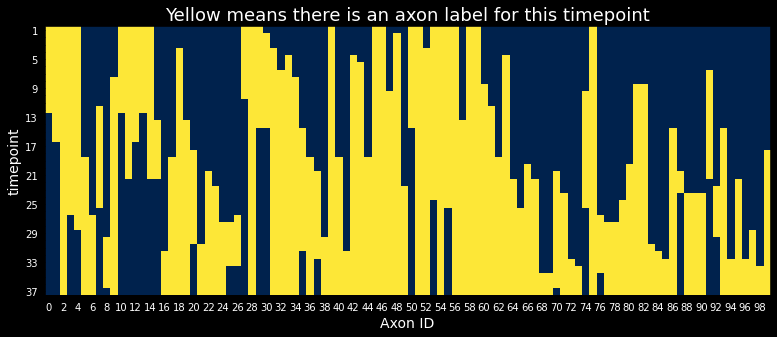

In [7]:
# LOAD AXONS AS LAYERS, or rgb image, show which timepoint is lablled 
as_shapes = True
print('LOADING axon bboxes....')
load_axons_range = range(100)

labelled = np.zeros((load_axons_range[-1]+1,sizet))
for i in load_axons_range:
    name = f'Axon_{i:0>3}'
    print(f'{name}...', end='')
    col = np.random.rand(1,3)
    dat = np.load(f'{outp_path}/labelled_axons/{name}.npy', )
    labelled[i,:] = [1 if t in dat[:,:,0].flatten() else 0 for t in range(sizet)]   # for plotting
    # dat[:,:,1] -= ymin
    # dat[:,:,2] -= xmin
    
    if not dat.size:
        print('!!!Empty!!!\n')
        continue
    dupl_label = any([(dat[:,:,0]==t).sum()>4 for t in range(sizet)])
    if dupl_label:
        [print(f't: {t} - More than one label!') for t in range(sizet) if (dat[:,:,0]==t).sum()>4]        
        print()
    else:
        print('Ok')
    if as_shapes:
        viewer.add_shapes(dat, name=name, shape_type='rectangle', edge_color=col, face_color=np.array([1,1,1,.9]), edge_width=5, visible=True, opacity=.9)
    else:
        start = dat[:, :,1:].min(axis=1).astype(int)
        end = dat[:,:,1:].max(axis=1).astype(int)
        x_start = start[:, 1]
        y_start = start[:, 0]
        x_end = end[:, 1]
        y_end = end[:, 0]
        
#         col = 1 - .35*(1-col) 
        axon_timepoints = dat[:,:,0].astype(int)
        for i, t in enumerate(range(axon_timepoints.min(), axon_timepoints.max()+1)):
            for w in range(2):
                rr, cc = rectangle_perimeter((y_start[i]+w, x_start[i]+w), end=(y_end[i]+w, x_end[i]+w), 
                                             shape=rgb_image.shape[1:])
                rgb_image[t-1, rr, cc] = col

plt.figure(figsize=(13,7), facecolor='k')
plt.imshow(labelled.T, cmap=plt.get_cmap('cividis'))
ax = plt.gca()

ax.set_yticks(np.arange(sizet))
ax.set_yticklabels(['' if t%5 else t for t in range(sizet)], color='white')
ax.set_ylabel('timepoint', color='white', fontsize=14)

ax.set_xticks(np.arange(load_axons_range[-1]+1))
ax.set_xticklabels(['' if t%2 else t for t in range(load_axons_range[-1]+1)], color='white')
ax.set_xlabel('Axon ID', color='white', fontsize=14)

ax.set_title('Yellow means there is an axon label for this timepoint', color='white', fontsize=18)
ax.set_yticks(np.arange(sizet))
ax.set_yticklabels(['' if t%4 else t+1 for t in range(sizet)], color='white')
ax.set_ylabel('timepoint', color='white', fontsize=14)

In [12]:
viewer.add_image(rgb_image)

<Image layer 'rgb_image' at 0x7f64c2b87340>